<a href="https://colab.research.google.com/github/creative-dana/ds-cs-section2-sprint2/blob/master/n221-decision-trees/n221a_sol_decision_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 1*

# 📝 Assignment
---

# Decision Trees(결정트리)

## 캐글 인클래스(InClass) Competitions

### 1) EDA를 수행합시다

- [캐글 계정을 만드세요](https://www.kaggle.com/), 공유된 인클래스 대회 url을 통해 이동한 후 대회에 참여하세요.
- H1N1 데이터를 훈련/검증/테스트 셋으로 나누어 준비하세요
- profiling을 사용하여 데이터를 살펴보고, missing value, zeros, cardinarity 등을 확인하여 처리하세요.
- 본인만의 특성공학을 수행하세요.
- **(객관식) H1N1 분류기의 기준모델을 설정하세요. 기준모델의 정확도를 과제 제출폼에 제출하세요.**
    1. 0.24
    2. 0.50
    3. 0.76
    4. 1


In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from category_encoders import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

import graphviz
from sklearn.tree import export_graphviz

In [ ]:
target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'

train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

### 컬럼 설명

In [ ]:
# 컬럼명 확인
train.columns

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_insurance',
       'health_worker', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'agegrp',
       'education_comp', 'raceeth4_i', 'sex_i', 'inc_pov', 'marital',
       'rent_own_r', 'employment_status', 'census_region', 'census_msa',
       'n_adult_r', 'household_children', 'n_people_r', 'employment_industry',
       'employment_occupation', 'hhs_region', 'state', 'vacc_h1n1_f'],
      dtype='object')

targets
  - vacc_h1n1_f : H1N1독감 백신 반응 (이 문제의 label)
  - vacc_ease_f : 계절성 독감 백신 반응


모든 binary binary 변수는 다음과 같은 규칙을 따릅니다.
0 : No / 1 : Yes

1. h1n1_concern : H1N1백신에 대한 우려 정도
    - 0 : 전혀 우려되지 않음
    - 1 : 그다지 우려되지 않음
    - 2 : 다소 우려됨
    - 3 : 매우 걱정됨

2. h1n1_knowledge : H1N1백신에 대해 얼마나 잘 알고 있는가?
    - 0 : 아는 것이 전혀 없다
    - 1 : 조금 알고 있다.
    - 2 : 매우 잘 알고 있다.

3. behavioral_antiviral_meds - 항생제 복용 여부 (binary)

4. behavioral_avoidance - 독감 유증상자와의 접촉을 피해왔는가?

5. behavioral_face_mask - 마스크를 착용 하였는가?

6. behavioral_wash_hands - 손을 자주 씻거나 세정제를 사용하였는가? 

7. behavioral_large_gatherings - 대규모 집단 모임 참석을 줄였는가? 

8. behavioral_outside_home - 동거인 외의 사람들과의 접촉을 피하였는가?

9. behavioral_touch_face - 눈, 코, 입 등을 만지지 않았는가?

10. doctor_recc_h1n1 - 의사에게 H1N1독감 백신 투여를 권유받았는가? 

11. doctor_recc_seasonal - 의사에게 계절성 독감 백신 투여를 권유받았는가?

12. chronic_med_condition - 다음의 만성질환으로 인해 약물을 복용하고 있는가? (다음 : 천식 또는 기타 폐 질환, 당뇨병, 심장 질환, 신장 질환, 겸상 적혈구 빈혈 또는 기타 빈혈, 신경 학적 또는 신경근 질환, 간 질환 또는 만성 질환 또는 약물 복용으로 인한 면역 체계 약화 만성 질환)

13. child_under_6_months - 6개월 미만 영아와 정기적으로 긴밀히 접촉을 한 적이 있는가?

14. health_insurance - 건강 보험에 가입되어 있는가?

15. health_worker - 의료계 종사자인가?

16. opinion_h1n1_vacc_effective H1N1백신의 효과에 대한 응답자의 생각
    - Not at all effective
    - Not very effective
    - Don't know
    - Somewhat effective
    - Very effective

17. opinion_h1n1_risk - H1N1백신의 위험에 대한 응답자의 생각
    - Very Low
    - Somewhat low
    - Don't know
    - Somewhat high
    - Very high

18. opinion_h1n1_sick_from_vacc - H1N1백신 투여 후 질병에 걸릴 수도 있는 위험에 대한 응답자의 생각 
    - Not at all worried
    - Not very worried
    - Don't know
    - Somewhat worried
    - Very worried

19. opinion_seas_vacc_effective - 계절성 백신의 효과에 대한 응답자의 생각
    - Not very effective
    - Don't know
    - Somewhat effective
    - Very effective

20. opinion_seas_risk - 계절성 백신의 위험에 대한 응답자의 생각
    - Very Low
    - Somewhat low
    - Don't know
    - Somewhat high
    - Very high

21. opinion_seas_sick_from_vacc - 계절성 백신 투여 후 질병에 걸릴 수도 있는 위험에 대한 응답자의 생각
    - Not at all worried
    - Not very worried
    - Don't know
    - Somewhat worried
    - Very worried

22. agegrp - 응답자의 연령별 그룹
    - 6 Months - 9 Years
    - 10 - 17 Years
    - 18 - 34 Years
    - 35 - 44 Years
    - 45 - 54 Years
    - 55 - 64 Years
    - 65+ Years

23. education_comp - 응답자 스스로가 답한 교육 이수 수준
    - 1 = < 12 Years
    - 2 = 12 Years
    - 3 = Some College
    - 4 = College Graduate

24. raceeth4_i - 응답자의 인종
    - 1 = Hispanic
    - 2 = Non-Hispanic, Black Only
    - 3 = Non-Hispanic, White Only
    - 4 = Non-Hispanic, Other or Multiple Races

25. sex_i - 응답자의 성별
  - 1 = Male
  - 2 = Female

24. inc_pov - 2008 년 인구 조사 빈곤 기준과 관련하여 응답자의 가구 연간 소득
    - 1 = > $75,000
    - 2 = <= $75,000
    - 3 = Below Poverty
    - 4 = Unknown

25. marital - 응답자의 결혼 여부
    - 1 = Married
    - 2 = Not Married

26. rent_own_r - 응답자의 거주 현황
    - 1 = Home is Owned
    - 2 = Home is Rented or Other Arrangement

27. employment_status - 응답자의 근로 현황
    - Employed
    - Not in Labor Force
    - Unemployed

28. census_region - 실제 인구 조사 거주 지역
    - 1=northeast
    - 2=midwest
    - 3=south
    - 4=west

29. census_msa -미국 인구 조사에서 정의한 대도시 통계 지역 (MSA) 내 응답자의 거주지.

30. n_adult_r - 거주 구성원 중 어른 인원 수

31. household_children - 거주 구성원 중 어린이 인원 수

32. n_people_r - 거주 구성원의 총 인원 수

33. employment_industry - 응답자가 종사하는 산업 구분

34. employment_occupation - 응답자의 직업 유형 (짧은 임의의 문자열로 표시)

35. hhs_region - HHS 감시 지역 번호
    - Region 1: CT,ME,MA,NH,RI,VT
    - Region 2: NJ,NY
    - Region 3: DE,DC,MD,PA,VA,WV
    - Region 4: AL,FL,GA,KY,MS,NC,SC,TN
    - Region 5: IL,IN,MI,MN,OH,WI
    - Region 6: AR,LA,NM,OK,TX
    - Region 7: IA,KS,MO,NE
    - Region 8: CO,MT,ND,SD,UT,WY
    - Region 9: AZ,CA,HI,NV
    - Region 10: AK,ID,OR,WA

36. state - 거주하는 주(州)

## EDA

In [ ]:
# 데이터 사이즈 확인
print("훈련 데이터 :",train.shape[0])
print("테스트 데이터 - features :", test.shape[0])

훈련 데이터 : 42154
테스트 데이터 - features : 28104


In [ ]:
# 데이터 타입 확인 - 훈련용
train.dtypes

# 실수, 정수, 카테고리 (= objects) 타입 확인

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_insurance               float64
health_worker                  float64
opinion_h1n1_vacc_effective     object
opinion_h1n1_risk               object
opinion_h1n1_sick_from_vacc     object
opinion_seas_vacc_effective     object
opinion_seas_risk               object
opinion_seas_sick_from_vacc     object
agegrp                          object
education_comp                 float64
raceeth4_i                       int64
sex_i                            int64
inc_pov                  

In [ ]:
# 데이터 타입 확인 - 테스트용
test.dtypes

# 실수, 정수, 카테고리 (= objects) 타입 확인

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_insurance               float64
health_worker                  float64
opinion_h1n1_vacc_effective     object
opinion_h1n1_risk               object
opinion_h1n1_sick_from_vacc     object
opinion_seas_vacc_effective     object
opinion_seas_risk               object
opinion_seas_sick_from_vacc     object
agegrp                          object
education_comp                 float64
raceeth4_i                       int64
sex_i                            int64
inc_pov                  

In [ ]:
# 데이터 중복값 확인 - 훈련용
train.T.duplicated()

# 중복값 없음

h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_insurance               False
health_worker                  False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
agegrp                         False
education_comp                 False
raceeth4_i                     False
sex_i                          False
inc_pov                        False
marital                        False
r

In [ ]:
# 데이터 중복값 확인 - 테스트용
test.T.duplicated()

# 중복값 없음

h1n1_concern                   False
h1n1_knowledge                 False
behavioral_antiviral_meds      False
behavioral_avoidance           False
behavioral_face_mask           False
behavioral_wash_hands          False
behavioral_large_gatherings    False
behavioral_outside_home        False
behavioral_touch_face          False
doctor_recc_h1n1               False
doctor_recc_seasonal           False
chronic_med_condition          False
child_under_6_months           False
health_insurance               False
health_worker                  False
opinion_h1n1_vacc_effective    False
opinion_h1n1_risk              False
opinion_h1n1_sick_from_vacc    False
opinion_seas_vacc_effective    False
opinion_seas_risk              False
opinion_seas_sick_from_vacc    False
agegrp                         False
education_comp                 False
raceeth4_i                     False
sex_i                          False
inc_pov                        False
marital                        False
r

In [ ]:
# 데이터 결측치 확인 - 훈련용
# 참고 : 훈련용 데이터는 42,154개
train.isnull().sum()

# health_insurance, employment_industry, employment_occupation의 경우 결측치가 50%에 육박함.

h1n1_concern                    8420
h1n1_knowledge                  8420
behavioral_antiviral_meds       8519
behavioral_avoidance            8672
behavioral_face_mask            8444
behavioral_wash_hands           8471
behavioral_large_gatherings     8514
behavioral_outside_home         8521
behavioral_touch_face           8583
doctor_recc_h1n1                1885
doctor_recc_seasonal            1885
chronic_med_condition           1317
child_under_6_months            9449
health_insurance               19421
health_worker                   9430
opinion_h1n1_vacc_effective     8779
opinion_h1n1_risk               8825
opinion_h1n1_sick_from_vacc     8869
opinion_seas_vacc_effective     8934
opinion_seas_risk               9001
opinion_seas_sick_from_vacc     9065
agegrp                             0
education_comp                 10166
raceeth4_i                         0
sex_i                              0
inc_pov                            0
marital                        10199
r

In [ ]:
# 데이터 결측치 확인 - 테스트용
# 참고 : 테스트용 데이터는 28,104개
test.isnull().sum()

# health_insurance : 결측치가 50%에 육박함.
# employment_industry, employment_occupation : 결측치가 50% 이상

h1n1_concern                    5612
h1n1_knowledge                  5612
behavioral_antiviral_meds       5672
behavioral_avoidance            5810
behavioral_face_mask            5626
behavioral_wash_hands           5648
behavioral_large_gatherings     5683
behavioral_outside_home         5682
behavioral_touch_face           5720
doctor_recc_h1n1                1207
doctor_recc_seasonal            1207
chronic_med_condition            854
child_under_6_months            6291
health_insurance               12740
health_worker                   6270
opinion_h1n1_vacc_effective     5864
opinion_h1n1_risk               5903
opinion_h1n1_sick_from_vacc     5933
opinion_seas_vacc_effective     5957
opinion_seas_risk               5993
opinion_seas_sick_from_vacc     6035
agegrp                             0
education_comp                  6811
raceeth4_i                         0
sex_i                              0
inc_pov                            0
marital                         6823
r

In [ ]:
# 결측치 많은 컬럼 상세 확인
# 1. helth_insurance
train["health_insurance"].value_counts()

1.0    20302
0.0     2431
Name: health_insurance, dtype: int64

In [ ]:
# 결측치 개수 재확인
train["health_insurance"].isnull().sum()

19421

In [ ]:
# 결측치 실제 값 확인 -> NaN
# yes/no의 구분이기 때문에 결측치를 평균값으로 채운다던지등의 선택은 할 수 없다.
train[train["health_insurance"].isnull()].head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
1,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,Very Effective,Somewhat Low,Not At All Worried,45 - 54 Years,3.0,3,1,2,2.0,1.0,Employed,2,"MSA, Principle City",1.0,0.0,1.0,Accommodation and Food Services Industries,Food Preparation and Serving Related Occupations,7,NEBRASKA,0
2,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Very Worried,Somewhat Effective,Somewhat Low,Very Worried,45 - 54 Years,3.0,3,1,2,2.0,2.0,Employed,1,"MSA, Not Principle City",1.0,2.0,3.0,Transportation and Warehousing Industries,Transportation and Material Moving Occupations,1,MASSACHUSETTS,0
7,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,Not Very Effective,Very Low,Not At All Worried,Not Very Effective,Very Low,Not At All Worried,18 - 34 Years,3.0,3,1,2,2.0,1.0,Employed,2,"MSA, Not Principle City",2.0,0.0,2.0,Construction Industries,Management Occupations,7,MISSOURI,0
8,2.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,NaN,NaN,0.0,0.0,NaN,0.0,Dont Know,Somewhat Low,Not At All Worried,Somewhat Effective,Somewhat Low,Not At All Worried,35 - 44 Years,3.0,1,1,2,1.0,1.0,Employed,2,"MSA, Not Principle City",2.0,2.0,4.0,Manufacturing Industries,Transportation and Material Moving Occupations,5,WISCONSIN,0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 Months - 9 Years,NaN,1,2,2,NaN,2.0,NaN,3,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,4,FLORIDA,0


In [ ]:
# 결측치 많은 컬럼을 상세하게 확인해보기
# 2. employment_industry
train["employment_industry"].value_counts()

Health Care and Social Assistance Industries                     3086
Education Services Industries                                    2298
Professional, Scientific, and Technical Services Industries      1535
Retail Trade Industries                                          1360
Construction Industries                                          1115
Public Administration Industries                                 1103
Manufacturing Industries                                         1062
Finance and Insurance Industries                                  778
Other Services (except Public)                                    717
Accommodation and Food Services Industries                        672
Transportation and Warehousing Industries                         637
Information Industries                                            426
Administrative and Support and Waste Management                   416
Agriculture, Forestry, Fishing, and Hunting Industries            377
Arts, Entertainment,

In [ ]:
# 결측치 개수 재확인
train["employment_industry"].isnull().sum()

24989

In [ ]:
# 결측치 실제 값 확인 -> NaN
train[train["employment_industry"].isnull()].head(5)

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,employment_industry,employment_occupation,hhs_region,state,vacc_h1n1_f
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10 - 17 Years,NaN,3,1,2,NaN,2.0,NaN,4,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,9,CALIFORNIA,0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10 - 17 Years,NaN,3,2,1,NaN,1.0,NaN,2,"MSA, Not Principle City",3.0,1.0,4.0,NaN,NaN,7,MISSOURI,0
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 Months - 9 Years,NaN,1,2,2,NaN,2.0,NaN,3,"MSA, Not Principle City",2.0,3.0,5.0,NaN,NaN,4,FLORIDA,0
10,2.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Very Effective,Refused,Somewhat Worried,Somewhat Effective,Somewhat High,Not At All Worried,35 - 44 Years,3.0,2,2,3,1.0,1.0,Not in Labor Force,2,"MSA, Not Principle City",2.0,1.0,3.0,NaN,NaN,7,MISSOURI,0
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6 Months - 9 Years,NaN,3,1,1,NaN,1.0,NaN,3,"MSA, Not Principle City",2.0,2.0,4.0,NaN,NaN,4,ALABAMA,1


In [ ]:
# employment_industry, employment_occupation : 결측치 개수 가장 많음. 개수 서로 동일
# cardinality 확인 후 너무 복잡하면 과감하게 Drop
# cardinality 확인은 데이터타입이 object인 것만 진행
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
employment_status,31876,3,Employed,17173
census_msa,42154,3,"MSA, Not Principle City",18957
opinion_h1n1_vacc_effective,33375,6,Somewhat Effective,14729
opinion_h1n1_risk,33329,6,Somewhat Low,12520
opinion_h1n1_sick_from_vacc,33285,6,Not Very Worried,11582
opinion_seas_vacc_effective,33220,6,Somewhat Effective,14543
opinion_seas_risk,33153,6,Somewhat Low,11397
opinion_seas_sick_from_vacc,33089,6,Not At All Worried,14749
agegrp,42154,7,65+ Years,8517
employment_industry,17165,23,Health Care and Social Assistance Industries,3086


In [ ]:
# 불필요한 컬럼 삭제 1
# cardinality가 가장 높은 3개 컬럼 삭제 (테스트, 훈련용 모두 동일하게 진행할 것)
train_cleaned_1 = train.drop(["employment_industry","employment_occupation","state"], axis=1)
test_cleaned_1 = test.drop(["employment_industry","employment_occupation","state"], axis=1)

# 삭제 후 특성 개수 확인 (36,35개로 줄어들었음을 확인)
train_cleaned_1.shape, test_cleaned_1.shape

((42154, 36), (28104, 35))

In [ ]:
# 불필요한 컬럼 삭제 2
# 우리가 알고자 하는 것은 H1N1 독감 관련 정보이므로, 계절성 독감 백신에 대한 의견은 필요 없음
train_cleaned_2 = train_cleaned_1.drop(["opinion_seas_vacc_effective","opinion_seas_risk","opinion_seas_sick_from_vacc"], axis=1)
test_cleaned_2 = test_cleaned_1.drop(["opinion_seas_vacc_effective","opinion_seas_risk","opinion_seas_sick_from_vacc"], axis=1)

# 특성 개수 확인 (33,32개로 줄어들었음을 확인)
train_cleaned_2.shape, test_cleaned_2.shape

((42154, 33), (28104, 32))

In [ ]:
# 새로운 컬럼 생성 1
# behavior 관련 컬럼 : 0과 1이며, 0은 전염병 예방에 부정적인 응답이고, 1은 긍정적인 응답.
# 해당 컬럼의 점수를 합치면 5점 만점이 되며, 5점일 수록 전염병 예방을 위한 노력을 해 왔다는 뜻이 되지 않을까?
# 모두 합쳐서 "behaviorals"라는 컬럼을 만든다.

# 함수 정의
def behavior(df):
  behaviorals = [col for col in df.columns if 'behavioral' in col] 
  df['behaviorals'] = df[behaviorals].sum(axis=1)


# 함수 실행
behavior(train_cleaned_2)
behavior(test_cleaned_2)

# 특성 개수 확인 (34,33개로 늘어났음을 확인)
train_cleaned_2.shape, test_cleaned_2.shape

((42154, 34), (28104, 33))

In [ ]:
# 새로운 컬럼 생성 2
# 응답자의 opinion과 관련된 컬럼은 점수로 바꾸어서 합산해 볼 수 있다.
# 1부터 5까지로 환산 후, sum을 하면 백신에 대해 긍정적/부정적 여부를 점수로 나타낼 수도 있지 않을까?

# 1. opinion_h1n1_vacc_effective 컬럼을 수치로 바꾼다.
"""
백신의 효과에 대한 응답자의 생각

5 : Very effective
4 : Somewhat effective
3 : Don't know
2 : Not very effective
1 : Not at all effective 
"""

# 값 확인
train_cleaned_2["opinion_h1n1_vacc_effective"].value_counts()

Somewhat Effective      14729
Very Effective           9052
Dont Know                6033
Not Very Effective       2312
Not At All Effective     1111
Refused                   138
Name: opinion_h1n1_vacc_effective, dtype: int64

In [ ]:
# 변환 과정에서 결측치가 나오면? -> 0으로 바꾼다.
# 결측치 보완 및 데이터 타입 일치효과
train_cleaned_2["opinion_h1n1_vacc_effective"].isnull().sum()

8779

In [ ]:
# 함수 정의
def effective(df):
  df["opinion_h1n1_vacc_effective_score"]=""
  
  for index in range(len(df)):
    opinion = df["opinion_h1n1_vacc_effective"][index]
    
    if opinion == "Very Effective":
      df["opinion_h1n1_vacc_effective_score"][index] = int(5)

    elif opinion == "Somewhat Effective":
      df["opinion_h1n1_vacc_effective_score"][index] = int(4)

    elif opinion == "Dont Know":
      df["opinion_h1n1_vacc_effective_score"][index] = int(3)

    elif opinion == "Not very effective":
      df["opinion_h1n1_vacc_effective_score"][index] = int(2)

    elif opinion == "Not at all effective":
      df["opinion_h1n1_vacc_effective_score"][index] = int(1)
      
    else:
      df["opinion_h1n1_vacc_effective_score"][index] = int(0)

  return df

In [ ]:
# 함수 실행
train_score = effective(train_cleaned_2)
test_score = effective(test_cleaned_2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

In [ ]:
# 점수 변환 확인 - 훈련용
train_score["opinion_h1n1_vacc_effective_score"].value_counts()

4    14729
0    12340
5     9052
3     6033
Name: opinion_h1n1_vacc_effective_score, dtype: int64

In [ ]:
# 점수 변환 확인 - 테스트용
test_score["opinion_h1n1_vacc_effective_score"].value_counts()

4    9935
0    8290
5    5923
3    3956
Name: opinion_h1n1_vacc_effective_score, dtype: int64

In [ ]:
# 2. opinion_h1n1_risk 컬럼을 수치로 바꾼다.
"""
H1N1백신의 위험에 대한 응답자의 생각
# Very Low
# Somewhat Low
# Dont Know
# Somewhat High
# Very High
"""

test_score["opinion_h1n1_risk"].value_counts()

Somewhat Low     8372
Very Low         6921
Somewhat High    4436
Very High        1452
Dont Know         983
Refused            37
Name: opinion_h1n1_risk, dtype: int64

In [ ]:
# 함수 정의
def risk(df):
  df["opinion_h1n1_risk_score"] = ""
  
  for index in range(len(df)):
    opinion = df["opinion_h1n1_risk"][index]
    
    if opinion == "Very Low":
      df["opinion_h1n1_risk_score"][index] = int(5)

    elif opinion == "Somewhat Low":
      df["opinion_h1n1_risk_score"][index] = int(4)

    elif opinion == "Dont Know":
      df["opinion_h1n1_risk_score"][index] = int(3)

    elif opinion == "Somewhat High":
      df["opinion_h1n1_risk_score"][index] = int(2)

    elif opinion == "Very High":
      df["opinion_h1n1_risk_score"][index] = int(1)
      
    else:
      df["opinion_h1n1_risk_score"][index] = 0

  return df

In [ ]:
risk(train_score)
risk(test_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,behaviorals,opinion_h1n1_vacc_effective_score,opinion_h1n1_risk_score
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Not At All Effective,Very Low,Not At All Worried,18 - 34 Years,1.0,3,2,2,2.0,1.0,Employed,2,"MSA, Not Principle City",2.0,0.0,2.0,7,0.0,0,5
1,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Dont Know,Dont Know,Dont Know,55 - 64 Years,NaN,3,1,4,NaN,NaN,NaN,3,"MSA, Principle City",1.0,0.0,1.0,6,3.0,3,3
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,65+ Years,3.0,3,1,2,2.0,1.0,Not in Labor Force,1,Non-MSA,1.0,0.0,1.0,1,3.0,5,5
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Somewhat High,Not Very Worried,65+ Years,4.0,3,1,4,1.0,1.0,Not in Labor Force,4,"MSA, Not Principle City",2.0,0.0,2.0,9,0.0,5,2
4,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Not Very Worried,65+ Years,2.0,3,1,2,2.0,1.0,Not in Labor Force,1,Non-MSA,1.0,0.0,1.0,1,3.0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28099,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Somewhat Effective,Somewhat Low,Not Very Worried,55 - 64 Years,3.0,3,1,3,2.0,2.0,Not in Labor Force,2,"MSA, Principle City",3.0,1.0,4.0,7,6.0,4,4
28100,3.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Somewhat Effective,Somewhat Low,Somewhat Worried,45 - 54 Years,2.0,3,2,2,1.0,1.0,Employed,3,"MSA, Not Principle City",2.0,0.0,2.0,4,4.0,4,4
28101,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,55 - 64 Years,2.0,3,1,1,1.0,1.0,Not in Labor Force,4,"MSA, Not Principle City",3.0,0.0,3.0,9,3.0,5,5
28102,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Somewhat Effective,Very High,Not At All Worried,35 - 44 Years,3.0,4,2,4,1.0,99.0,Employed,2,"MSA, Principle City",2.0,2.0,4.0,7,3.0,4,1


In [ ]:
# 점수 변환 확인 - 훈련용
train_score["opinion_h1n1_risk_score"].value_counts()

4    12520
5    10331
0     8901
2     6765
1     2156
3     1481
Name: opinion_h1n1_risk_score, dtype: int64

In [ ]:
# 점수 변환 확인 - 테스트용
train_score["opinion_h1n1_risk_score"].value_counts()

4    12520
5    10331
0     8901
2     6765
1     2156
3     1481
Name: opinion_h1n1_risk_score, dtype: int64

In [ ]:
# opinion_h1n1_sick_from_vacc 컬럼을 수치로 바꾼다.

"""
H1N1백신 투여 후 질병에 걸릴 수도 있는 위험(= 부작용)에 대한 응답자의 생각

Not at all worried
Not very worried
Don't know
Somewhat worried
Very worried
"""

train_score["opinion_h1n1_sick_from_vacc"].value_counts()

Not Very Worried      11582
Not At All Worried    11253
Somewhat Worried       7480
Very Worried           2743
Dont Know               196
Refused                  31
Name: opinion_h1n1_sick_from_vacc, dtype: int64

In [ ]:
# 함수 정의
def sick_from_vacc(df):
  df["opinion_h1n1_sick_from_vacc_score"] = ""
  
  for index in range(len(df)):
    opinion = df["opinion_h1n1_sick_from_vacc"][index]
    
    if opinion == "Not At All Worried":
      df["opinion_h1n1_sick_from_vacc_score"][index] = int(5)

    elif opinion == "Not Very Worried":
      df["opinion_h1n1_sick_from_vacc_score"][index] = int(4)

    elif opinion == "Dont Know":
      df["opinion_h1n1_sick_from_vacc_score"][index] = int(3)

    elif opinion == "Somewhat Worried":
      df["opinion_h1n1_sick_from_vacc_score"][index] = int(2)

    elif opinion == "Very Worried":
      df["opinion_h1n1_sick_from_vacc_score"][index] = int(1)
      
    else:
      df["opinion_h1n1_sick_from_vacc_score"][index] = 0

  return df

In [ ]:
sick_from_vacc(train_score)
sick_from_vacc(test_score)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_insurance,health_worker,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,agegrp,education_comp,raceeth4_i,sex_i,inc_pov,marital,rent_own_r,employment_status,census_region,census_msa,n_adult_r,household_children,n_people_r,hhs_region,behaviorals,opinion_h1n1_vacc_effective_score,opinion_h1n1_risk_score,opinion_h1n1_sick_from_vacc_score
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,Not At All Effective,Very Low,Not At All Worried,18 - 34 Years,1.0,3,2,2,2.0,1.0,Employed,2,"MSA, Not Principle City",2.0,0.0,2.0,7,0.0,0,5,5
1,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,Dont Know,Dont Know,Dont Know,55 - 64 Years,NaN,3,1,4,NaN,NaN,NaN,3,"MSA, Principle City",1.0,0.0,1.0,6,3.0,3,3,3
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,65+ Years,3.0,3,1,2,2.0,1.0,Not in Labor Force,1,Non-MSA,1.0,0.0,1.0,1,3.0,5,5,4
3,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Somewhat High,Not Very Worried,65+ Years,4.0,3,1,4,1.0,1.0,Not in Labor Force,4,"MSA, Not Principle City",2.0,0.0,2.0,9,0.0,5,2,4
4,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,Somewhat Effective,Somewhat Low,Not Very Worried,65+ Years,2.0,3,1,2,2.0,1.0,Not in Labor Force,1,Non-MSA,1.0,0.0,1.0,1,3.0,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28099,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Somewhat Effective,Somewhat Low,Not Very Worried,55 - 64 Years,3.0,3,1,3,2.0,2.0,Not in Labor Force,2,"MSA, Principle City",3.0,1.0,4.0,7,6.0,4,4,4
28100,3.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Somewhat Effective,Somewhat Low,Somewhat Worried,45 - 54 Years,2.0,3,2,2,1.0,1.0,Employed,3,"MSA, Not Principle City",2.0,0.0,2.0,4,4.0,4,4,2
28101,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,Very Effective,Very Low,Not Very Worried,55 - 64 Years,2.0,3,1,1,1.0,1.0,Not in Labor Force,4,"MSA, Not Principle City",3.0,0.0,3.0,9,3.0,5,5,4
28102,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Somewhat Effective,Very High,Not At All Worried,35 - 44 Years,3.0,4,2,4,1.0,99.0,Employed,2,"MSA, Principle City",2.0,2.0,4.0,7,3.0,4,1,5


In [ ]:
# 점수 변환 확인 - 훈련용
train_score["opinion_h1n1_sick_from_vacc_score"].value_counts()

4    11582
5    11253
0     8900
2     7480
1     2743
3      196
Name: opinion_h1n1_sick_from_vacc_score, dtype: int64

In [ ]:
# 점수 변환 확인 - 테스트용
test_score["opinion_h1n1_sick_from_vacc_score"].value_counts()

4    7693
5    7618
0    5946
2    4920
1    1799
3     128
Name: opinion_h1n1_sick_from_vacc_score, dtype: int64

In [ ]:
# opinion score를 합산 후 불필요한 컬럼 삭제 - 훈련용 데이터
tmp = train_score.iloc[:, -3:].sum(axis=1)
train_score["opinion_score"] = ""

for index in range(len(train_score)):
  train_score["opinion_score"][index] = tmp[index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 확인
train_score["opinion_score"].value_counts()

0.0     8791
13.0    5553
12.0    5350
10.0    5167
11.0    3905
14.0    3664
9.0     2896
8.0     2894
7.0     1522
15.0    1030
6.0      898
5.0      246
4.0      102
3.0       98
2.0       35
1.0        3
Name: opinion_score, dtype: int64

In [ ]:
# opinion score를 합산 후 불필요한 컬럼 삭제 - 테스트용 데이터
tmp = test_score.iloc[:, -3:].sum(axis=1)
test_score["opinion_score"] = ""

for index in range(len(test_score)):
  test_score["opinion_score"][index] = tmp[index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 확인
test_score["opinion_score"].value_counts()

0.0     5872
12.0    3741
13.0    3619
10.0    3329
11.0    2546
14.0    2485
9.0     1939
8.0     1905
7.0     1014
15.0     709
6.0      613
5.0      149
4.0       83
3.0       70
2.0       30
Name: opinion_score, dtype: int64

In [ ]:
# 불필요한 컬럼 삭제
drop = ["opinion_h1n1_vacc_effective_score","opinion_h1n1_risk_score","opinion_h1n1_sick_from_vacc_score"]

train_final = train_score.drop(drop,axis=1)
test_final = test_score.drop(drop,axis=1)

In [ ]:
# 데이터 셋 나누기
# 1. train, validation, test 3종류로 나누기
# 2. 각각의 데이터 셋을 features와 target으로 나누기
train_target = train_final[target]
train_features = train_final.drop(target, axis=1)


X_train, X_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.2, random_state = 0)

X_test = test_final

In [ ]:
# 최종 데이터 셋 확인
print("훈련용 데이터셋:", X_train.shape, y_train.shape)
print("검증용 데이터셋:", X_val.shape, y_val.shape)
print("테스트용 데이터셋:", X_test.shape)

훈련용 데이터셋: (33723, 34) (33723,)
검증용 데이터셋: (8431, 34) (8431,)
테스트용 데이터셋: (28104, 34)


In [ ]:
# H1N1 기준모델 생성
y_train.value_counts()

0    25742
1     7981
Name: vacc_h1n1_f, dtype: int64

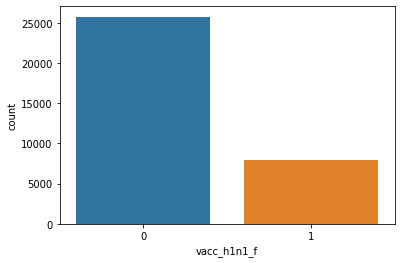

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.countplot(x=y_train);

In [ ]:
# mode(): Return the highest frequency value in a Series.
major = y_train.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트를 만듭니다. 기준모델로 예측
basic_model = [major] * len(y_train)

In [ ]:
# 기준모델의 정확도
print("training accuracy: ", accuracy_score(y_train, basic_model))

# 답은 3번 0.76

training accuracy:  0.7633365952020876


### 2) 모델 개발
- 결정트리를 학습시킵니다. 하이퍼파라미터를 수정하여 성능을 높여보세요. 과적합을 주의하세요!
- 검증세트 스코어를 확인하세요.(평가지표는 F1-score입니다, 수식은 캐글 Overview-Evaluation 페이지를 확인해 주세요. 평가지표에 대한 내용은 다음에 자세히 배우고 활용할 것입니다 지금은 스코어를 올리기 위한 노력을 전혀 기울이지 말고 결정트리의 개념과 코드이해, 사용에 집중하세요!)
- 특성중요도를 그래프로 나타내 보세요
- **검증세트의 F1-score를 과제 제출폼에 제출하세요. (0.5 이상 통과)**

In [ ]:
# 시도 1.
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True),  
    SimpleImputer(), 
    DecisionTreeClassifier(random_state=2, criterion='entropy') 
)

# 모델 훈련
pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

# 검증세트로 평가
y_pred = pipe.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.9919639415235892
검증 정확도:  0.7560194520222987
검증 f1:  0.5039787798408488


In [ ]:
# 시도 2.
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=4, random_state=2, criterion='entropy')
)

# 모델 훈련
pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

# 검증세트로 평가
y_pred = pipe.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.8200634581739465
검증 정확도:  0.8200687937373977
검증 f1:  0.5451274362818591


In [ ]:
# 시도 3.
pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=2, criterion='entropy')
)

# 모델 훈련
pipe.fit(X_train, y_train)
print('훈련 정확도: ', pipe.score(X_train, y_train))
print('검증 정확도: ', pipe.score(X_val, y_val))

# 검증세트로 평가

y_pred = pipe.predict(X_val)
print('검증 f1: ', f1_score(y_val, y_pred))

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


훈련 정확도:  0.8200634581739465
검증 정확도:  0.8200687937373977
검증 f1:  0.5451274362818591


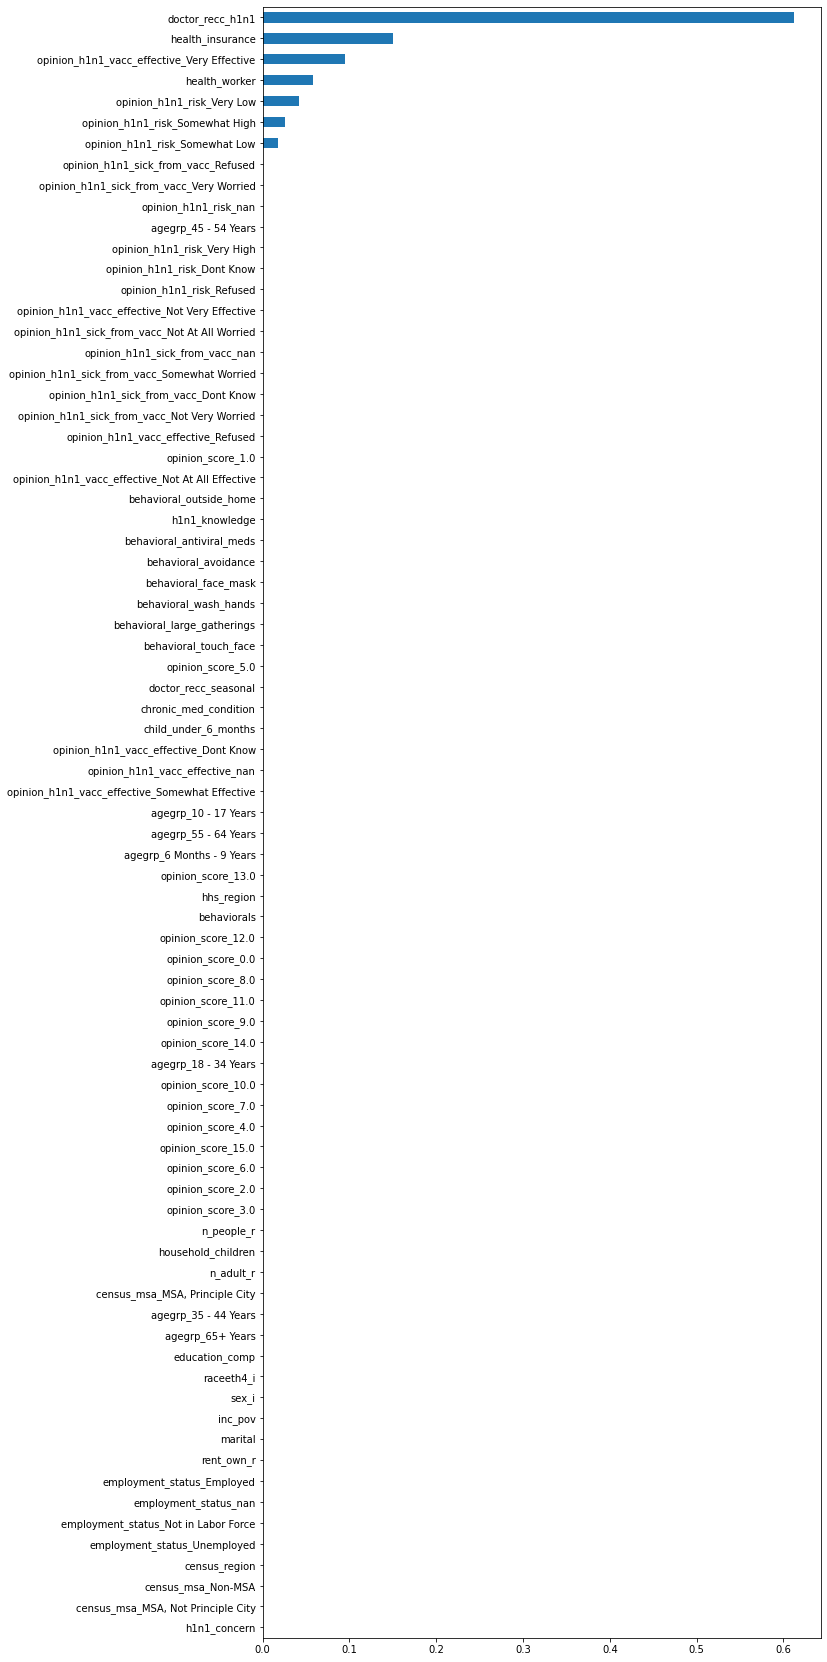

In [ ]:
# named_steps으로 특성 중요도 확인
enc = pipe.named_steps['onehotencoder']
encoded_columns = enc.transform(X_val).columns

model_dt = pipe.named_steps['decisiontreeclassifier']

importances = pd.Series(model_dt.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh();

### 3) 캐글 대회 참여

- 테스트셋에 대한 예측 결과를 캐글에 제출 하세요.(스코어가 많이 낮게 나와도 결정트리를 잘 이해하고 결과를 내었다면 충분합니다!)
- **캐글 Leaderboard의 본인 Score를 과제 제출폼에 제출하세요.**
 

In [ ]:
# csv 파일 저장을 위한 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# test 데이터의 feature를 사용하여 예측값 도출
y_pred_test = pipe.predict(X_test)

In [ ]:
# 예측값을 제출 form에 저장
sample_submission[target] = y_pred_test
sample_submission

,Id,vacc_h1n1_f
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
28099,28099,0
28100,28100,0
28101,28101,0
28102,28102,0


In [ ]:
# 개수 확인 (예측값에서 0, 1 개수 확인)
(y_pred_test == 0).sum(), (y_pred_test == 1).sum()

(24058, 4046)

In [ ]:
# 개수 확인 (제출폼 데이터프레임에서 0, 1 개수 확인)
sample_submission[target].value_counts()

0    24058
1     4046
Name: vacc_h1n1_f, dtype: int64

In [ ]:
# 저장
sample_submission.to_csv("/content/drive/MyDrive/ds-cs-section2-sprint2-master/n221-decision-trees/submission_dana.csv", index = False)

## 🔥 도전과제

### 4) 다른 종류의 imputer를 사용하고 특성-타겟 관계 그래프를 나타내 보세요.
- 다른 종류의 imputer를 사용해 보세요([scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html))
- seaborn plots 사용하여 관심있는 특성들과 target간의 관계를 그래프로 나타내 보세요.
- [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html)
- [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html)

In [ ]:
### 이곳에서 과제를 진행해 주세요 ###